## Preprocessing

### Read

In [1]:
import pandas as pd
import re
import spacy

import torch
from torch_geometric.data import HeteroData

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [2]:
import json

def read_first_n_lines(file_path, n=10000):
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= n:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

# Pfad zu Ihrer JSON-Datei
file_path = 'data/arxiv-metadata-oai-snapshot.json'

# DataFrame erstellen
df = read_first_n_lines(file_path, 3)


In [3]:
df.dtypes

id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object

In [4]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"


### Transform columns

In [6]:
# extract number of pages from string: e.g. "37 pages, 15 figures; published version"

def extract_pages(s):
    match = re.search(r"(\d+)\s*pages", s)
    if match:
        return int(match.group(1))
    else:
        return None

In [7]:
# format columns to right format and extract information
# Quelle warum genau die neuen Spalten fürPaper suchen
# df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(author).strip() for author in (eval(x) if isinstance(x, str) else x)])

df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(i).strip() for i in (eval(x) if isinstance(x, str) else x)]) # authors to name, first name and list
df['versions'] = df['versions'].apply(lambda x: eval(x)[0]["created"] if isinstance(x, str) else x) # first version / created
df['timestamp'] = df['versions'].apply(lambda x: x[0]['created'] if isinstance(x, list) and len(x) > 0 else None)
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%a, %d %b %Y %H:%M:%S %Z", errors='coerce')
df["categories"] = df["categories"].apply(lambda x: x.split(" ")) # sdeperate categories by comma
df.drop(columns=["submitter", "versions", "update_date", "authors"], inplace=True)
df["pages"] = df.comments.apply(lambda x: extract_pages(str(x))) # extract page number
df.head()

,id,title,comments,journal-ref,doi,report-no,categories,license,abstract,authors_parsed,timestamp,pages
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,[hep-ph],None,A fully differential calculation in perturba...,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",2007-04-02 19:18:42+00:00,37.0
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[Streinu Ileana, Theran Louis]",2007-03-31 02:26:18+00:00,NaN
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,[physics.gen-ph],None,The evolution of Earth-Moon system is descri...,[Pan Hongjun],2007-04-01 20:46:54+00:00,23.0


### Define size of dataset

In [8]:
df_short = df.drop_duplicates(subset='title', keep='first')
df_short = df_short.reset_index(drop=True)

### Lemmatization

In [10]:
nlp = spacy.load("en_core_web_sm")

def lemm(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

In [11]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("en_core_web_sm")
def lemma(docs=df.abstract):
    pip = nlp.pipe(docs, batch_size=32, n_process=-1, disable=["parser", "ner"])
    return [
        [tok.lemma_ for tok in doc if not tok.is_punct and not tok.is_space]
        for doc in tqdm(pip, total=len(docs))
    ]

all_words = lemma(df_short["abstract"])
all_title_words = lemma(df_short["title"])

all_title_words

c:\Users\Ilgar\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [00:47<00:00, 15.93s/it]


[['calculation',
  'of',
  'prompt',
  'diphoton',
  'production',
  'cross',
  'section',
  'at',
  'Tevatron',
  'and',
  'LHC',
  'energy'],
 ['sparsity', 'certify', 'Graph', 'Decompositions'],
 ['the',
  'evolution',
  'of',
  'the',
  'Earth',
  'Moon',
  'system',
  'base',
  'on',
  'the',
  'dark',
  'matter',
  'field',
  'fluid',
  'model']]

In [12]:
# create lists that contain lemmatized words from abstracts, titles, and lists of authors and categories for each entry in the DataFrame



all_authors, all_categories= [], []


for index, row in df_short.iterrows():
    text = row['abstract']
    title = row['title']
    author = row['authors_parsed']
    category = row['categories'] 
    all_authors.append(author)
    all_categories.append(category)



print(all_authors)
print(all_categories)

[['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.', 'Yuan C. -P.'], ['Streinu Ileana', 'Theran Louis'], ['Pan Hongjun']]
[['hep-ph'], ['math.CO', 'cs.CG'], ['physics.gen-ph']]


### Delete Stopwords

In [13]:
# !pip3 install nltk

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Laden der Stoppwörter
stop_words = set(stopwords.words('english'))

# Entfernen der Stoppwörter aus jedem Dokument
filtered_all_words = []
for words in all_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_all_words.append(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilgar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [16]:
filtered_all_words

[['fully',
  'differential',
  'calculation',
  'perturbative',
  'quantum',
  'chromodynamic',
  'present',
  'production',
  'massive',
  'photon',
  'pair',
  'hadron',
  'collider',
  'next',
  'lead',
  'order',
  'perturbative',
  'contribution',
  'quark',
  'antiquark',
  'gluon-(anti)quark',
  'gluon',
  'gluon',
  'subprocesse',
  'include',
  'well',
  'order',
  'resummation',
  'initial',
  'state',
  'gluon',
  'radiation',
  'valid',
  'next',
  'next',
  'lead',
  'logarithmic',
  'accuracy',
  'region',
  'phase',
  'space',
  'specify',
  'calculation',
  'reliable',
  'good',
  'agreement',
  'demonstrate',
  'datum',
  'Fermilab',
  'Tevatron',
  'prediction',
  'make',
  'detailed',
  'test',
  'CDF',
  'datum',
  'prediction',
  'show',
  'distribution',
  'diphoton',
  'pair',
  'produce',
  'energy',
  'Large',
  'Hadron',
  'Collider',
  'LHC',
  'distribution',
  'diphoton',
  'pair',
  'decay',
  'Higgs',
  'boson',
  'contrast',
  'produce',
  'QCD',
  'proc

### List with every word

In [17]:
# create lists with every value without double lists

words_values = [word for sublist in filtered_all_words for word in sublist]

print(words_values)

authors_values = [author for sublist in all_authors for author in sublist]

categories_values = [category for sublist in all_categories for category in sublist]

title_values = [title for sublist in all_title_words for title in sublist]

['fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamic', 'present', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'next', 'lead', 'order', 'perturbative', 'contribution', 'quark', 'antiquark', 'gluon-(anti)quark', 'gluon', 'gluon', 'subprocesse', 'include', 'well', 'order', 'resummation', 'initial', 'state', 'gluon', 'radiation', 'valid', 'next', 'next', 'lead', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'calculation', 'reliable', 'good', 'agreement', 'demonstrate', 'datum', 'Fermilab', 'Tevatron', 'prediction', 'make', 'detailed', 'test', 'CDF', 'datum', 'prediction', 'show', 'distribution', 'diphoton', 'pair', 'produce', 'energy', 'Large', 'Hadron', 'Collider', 'LHC', 'distribution', 'diphoton', 'pair', 'decay', 'Higgs', 'boson', 'contrast', 'produce', 'QCD', 'process', 'LHC', 'show', 'enhance', 'sensitivity', 'signal', 'obtain', 'judicious', 'selection', 'event', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-peb

### Delete duplicates

In [25]:
categories_list = set(categories_values)
authors_list = set(authors_values)
title_words_list = set(title_values)
words_list = set(words_values)

### Liste mit allen Attributen erstellen

In [29]:
licenses_list = df_short['license'].tolist()

doi_list = df_short['doi'].tolist()

title_list = df_short['title'].tolist()

comment_list = df_short['comments'].tolist()

journal_list = df_short['journal-ref'].tolist()

words_in_title_list = df_short['title'].tolist()

date_list = df_short['timestamp'].tolist()

id_list = df_short['id'].tolist()

pages_list = df_short['pages'].tolist()

In [31]:
licenses_list

[None, 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', None]

## Create Hetero Object

In [41]:
data = HeteroData()
data['paper'].num_nodes = len(df_short)
data['paper'].license = licenses_list
data['paper'].doi = doi_list
data['paper'].title = title_list
data['paper'].pages = pages_list
data['paper'].journal = journal_list
data['paper'].date = date_list
data['paper'].id = id_list

data['author'].num_nodes = len(authors_list)
data['author'].name = authors_list

data['category'].num_nodes = len(categories_list)
data['category'].name = categories_list

data['journal'].num_nodes = len(df_short)
data['journal'].name = journal_list

data['word'].num_nodes = len(words_list)
data['word'].name = words_list

data

HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    pages=[3],
    journal=[3],
    date=[3],
    id=[3],
  },
  author={
    num_nodes=7,
    name={'Pan Hongjun', 'Streinu Ileana', 'Yuan C. -P.', 'Balázs C.', 'Nadolsky P. M.', 'Berger E. L.', 'Theran Louis'},
  },
  category={
    num_nodes=4,
    name={'math.CO', 'hep-ph', 'cs.CG', 'physics.gen-ph'},
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=184,
    name={'attention', 'field', 'work', 'arboricity', 'beyond', 'Hendrickson', 'Earth', 'agreement', 'Moon', 'prediction', 'sensitivity', 'connection', 'QCD', 'good', 'problem', 'model', 'Particle', 'expose', 'k,\\ell)$-sparse', 'year', 'km', 'Large', 'demonstrate', 'massive', 'Mars', 'present', 'Fermilab', 'Lee', 'show', 'graph', 'calculation', 'new', 'instance', 'obtain', 'particular', 'Nash', 'may', 'generalize', 'American', 'accuracy', 'perturbative', 'close', 'Field', 's^(-1)m^(-1', 'Streinu', 'quantum', 'contribution

### Create edges

In [58]:
# Initialisierung der Dictionaries für das Mapping
id_to_paper = {}
id_to_author = {}

# Eindeutige IDs für Paper und Autoren erstellen
paper_id = 0
author_id = 0

edge_index_list_written_by = []
list_of_authors_ids = []
list_of_paper_ids = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers und des Autors aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper.values():
        id_to_paper[paper_id] = paper_title
        paper_id += 1

    authors_parsed = df_short['authors_parsed'][i]
    for author in authors_parsed:
        if author not in id_to_author.values():
            id_to_author[author_id] = author
            author_id += 1

        list_of_authors_ids.append(author_id -1)
        list_of_paper_ids.append(paper_id -1)

edge_index_list_written_by.append(list_of_paper_ids)
edge_index_list_written_by.append(list_of_authors_ids)

# Konvertiere die Liste in ein torch.Tensor-Objekt
edge_index_tensor_written_by = torch.tensor(edge_index_list_written_by, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'written_by', 'author'].edge_index = edge_index_tensor_written_by

In [59]:
edge_index_tensor_written_by

tensor([[0, 0, 0, 0, 1, 1, 2],
        [0, 1, 2, 3, 4, 5, 6]])

In [87]:
id_to_author

{0: 'Balázs C.',
 1: 'Berger E. L.',
 2: 'Nadolsky P. M.',
 3: 'Yuan C. -P.',
 4: 'Streinu Ileana',
 5: 'Theran Louis',
 6: 'Pan Hongjun'}

In [60]:
print(list_of_paper_ids[-1:])
print(torch.max(edge_index_tensor_written_by[0,:]))

print(list_of_authors_ids[-1:])
print(torch.max(edge_index_tensor_written_by[1,:]))

[2]
tensor(2)
[6]
tensor(6)


In [65]:
id_to_paper = {}
id_to_category = {}

# Eindeutige IDs für Paper und Kategorien erstellen
paper_id = 0
category_id = 0

edge_index_list_has_category = []
list_of_category_ids = []
list_of_cat_paper_ids = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers und der Kategorie aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper.values():
        id_to_paper[paper_id] = paper_title
        paper_id += 1

    categories = df_short['categories'][i]
    for category in categories:
        if category not in id_to_category.values():
            id_to_category[category_id] = category
            category_id += 1

        list_of_category_ids.append(category_id -1)
        list_of_cat_paper_ids.append(paper_id -1)

edge_index_list_has_category.append(list_of_cat_paper_ids)
edge_index_list_has_category.append(list_of_category_ids)

# Konvertiere die Liste in ein torch.Tensor-Objekt
edge_index_tensor_has_category = torch.tensor(edge_index_list_has_category, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_category', 'category'].edge_index = edge_index_tensor_has_category

In [66]:
edge_index_tensor_has_category

tensor([[0, 1, 1, 2],
        [0, 1, 2, 3]])

In [67]:
print(list_of_paper_ids[-1:])
print(torch.max(edge_index_tensor_has_category[0,:]))

print(list_of_category_ids[-1:])
print(torch.max(edge_index_tensor_has_category[1,:]))

[2]
tensor(2)
[3]
tensor(3)


In [70]:
id_to_paper = {}
id_to_word = {}

# Eindeutige IDs für Paper und Autoren erstellen
paper_id = 0
word_id = 0

edge_index_list_has_word = []
list_of_word_paper_ids = []
list_of_word_ids = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers und des Autors aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper.values():
        id_to_paper[paper_id] = paper_title
        paper_id += 1

    words = filtered_all_words[i]
    for word in words:
        if word not in id_to_word.values():
            id_to_word[word_id] = word
            word_id += 1

        list_of_word_paper_ids.append(paper_id -1)
        list_of_word_ids.append(word_id -1)

edge_index_list_has_word.append(list_of_word_paper_ids)
edge_index_list_has_word.append(list_of_word_ids)

# Konvertiere die Liste in ein torch.Tensor-Objekt
edge_index_tensor_has_word = torch.tensor(edge_index_list_has_word, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_tensor_has_word

In [71]:
edge_index_tensor_has_word

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2

In [72]:
print(list_of_paper_ids[-1:])
print(torch.max(edge_index_tensor_has_word[0,:]))

print(list_of_word_ids[-1:])
print(torch.max(edge_index_tensor_has_word[1,:]))

[2]
tensor(2)
[183]
tensor(183)


In [75]:
id_to_paper = {}
id_to_titleword = {}

# Eindeutige IDs für Paper und Autoren erstellen	
paper_id = 0
titleword_id = 0

edge_index_list_has_titleword = []
list_of_title_paper_ids = []
list_of_titleword_ids = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers und des Autors aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper.values():
        id_to_paper[paper_id] = paper_title
        paper_id += 1

    titlewords = all_title_words[i]
    for titleword in titlewords:
        if titleword not in id_to_titleword.values():
            id_to_titleword[titleword_id] = titleword
            titleword_id += 1

        list_of_title_paper_ids.append(paper_id -1)
        list_of_titleword_ids.append(titleword_id -1)

edge_index_list_has_titleword.append(list_of_title_paper_ids)
edge_index_list_has_titleword.append(list_of_titleword_ids)

# Konvertiere die Liste in ein torch.Tensor-Objekt
edge_index_tensor_has_titleword = torch.tensor(edge_index_list_has_titleword, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_titleword', 'word'].edge_index = edge_index_tensor_has_titleword

In [76]:
edge_index_tensor_has_titleword

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         17, 17, 18, 19, 20, 21, 22, 22, 23, 24, 25, 26, 27]])

In [77]:
print(list_of_paper_ids[-1:])
print(torch.max(edge_index_tensor_has_titleword[0,:]))

print(list_of_titleword_ids[-1:])
print(torch.max(edge_index_tensor_has_titleword[1,:]))

[2]
tensor(2)
[27]
tensor(27)


In [80]:
id_to_paper = {}
id_to_journal = {}

# Eindeutige IDs für Paper und Autoren erstellen
paper_id = 0
journal_id = 0

edge_index_list_in_journal = []
list_of_journal_paper_ids = []
list_of_journal_ids = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers und des Autors aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    if paper_title not in id_to_paper.values():
        id_to_paper[paper_id] = paper_title
        paper_id += 1

    journal = df_short['journal-ref'][i]
    if journal not in id_to_journal.values():
        id_to_journal[journal_id] = journal
        journal_id += 1

    list_of_journal_paper_ids.append(paper_id -1)
    list_of_journal_ids.append(journal_id -1)

edge_index_list_in_journal.append(list_of_journal_paper_ids)
edge_index_list_in_journal.append(list_of_journal_ids)

# Konvertiere die Liste in ein torch.Tensor-Objekt
edge_index_tensor_in_journal = torch.tensor(edge_index_list_in_journal, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_tensor_in_journal

In [81]:
edge_index_tensor_in_journal

tensor([[0, 1, 2],
        [0, 1, 1]])

In [82]:
print(list_of_paper_ids[-1:])
print(torch.max(edge_index_tensor_in_journal[0,:]))

print(list_of_journal_ids[-1:])
print(torch.max(edge_index_tensor_in_journal[1,:]))

[2]
tensor(2)
[1]
tensor(1)


### Assign weights

#### tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# TF-IDF Vektorizer
vectorizer = TfidfVectorizer()
corpus = [" ".join(words) for words in filtered_all_words]
tfidf_matrix = vectorizer.fit_transform(corpus)

# Erstellen eines Wörterbuches für Feature-Namen
feature_names = vectorizer.get_feature_names_out()
word_to_index = {word: idx for idx, word in enumerate(feature_names)}

# Initialisierung der Listen
list_of_paper_word = []
list_of_words = []
tfidf_weights = []

# Extraktion der TF-IDF-Werte
for i in range(len(df_short)):
    paper_title = df_short['title'][i]
    unique_words = set(filtered_all_words[i])  # Verwenden eines Sets zur Reduzierung von Duplikaten

    for word in unique_words:
        if word in word_to_index:
            word_index = word_to_index[word]
            tfidf_weight = tfidf_matrix[i, word_index]
            if tfidf_weight > 0:  # Fügen Sie nur Kanten für positive TF-IDF-Werte hinzu
                list_of_paper_word.append(paper_title)
                list_of_words.append(word)
                tfidf_weights.append(tfidf_weight)

# Erstellen der Kanten für das HeteroData-Objekt
edge_index_list_has_word = [[], []]
for paper_title, word in zip(list_of_paper_word, list_of_words):
    # Finde den Index des Papiers basierend auf dem Titel
    paper_idx = df_short.index[df_short['title'] == paper_title].tolist()
    if paper_idx:  # Sicherstellen, dass ein Index gefunden wurde
        paper_idx = paper_idx[0]
        word_idx = word_to_index[word]
        edge_index_list_has_word[0].append(paper_idx)
        edge_index_list_has_word[1].append(word_idx)

data['paper', 'has_word', 'word'].edge_index = torch.tensor(edge_index_list_has_word, dtype=torch.long)
data['paper', 'has_word', 'word'].edge_attr = torch.tensor(tfidf_weights, dtype=torch.float)

In [ ]:
len(edge_index_list_has_word)

2

<Axes: >

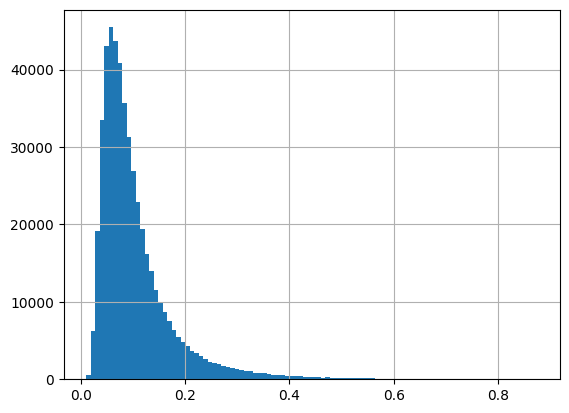

In [ ]:
# Erstellen eines DataFrame
tfidf_df = pd.DataFrame({
    'paper_title': list_of_paper_word,
    'word': list_of_words,
    'tfidf_weight': tfidf_weights
})
tfidf_df.tfidf_weight.hist(bins=100)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import Counter
# import math

# # TF-IDF Vektorizer
# vectorizer = TfidfVectorizer()
# corpus = [" ".join(words) for words in filtered_all_words]
# tfidf_matrix = vectorizer.fit_transform(corpus)

# feature_names = vectorizer.get_feature_names_out()
# feature_names_list = feature_names.tolist()

# edge_index_list_has_word, list_of_paper_word, list_of_words, tfidf_weights  = [], [], [], []

# for i in range(len(df_short)):
#     paper_title = df_short['title'][i]
#     words = filtered_all_words[i]

#     for word in words:
#         if word in feature_names:  # Prüfen, ob das Wort im Vektorizer vorhanden ist, Bindewörter nicht mehr drinnen
            
#             word_index = feature_names_list.index(word)
#             tfidf_weight = tfidf_matrix[i, word_index]

#             list_of_paper_word.append(paper_title)
#             list_of_words.append(word)
#             tfidf_weights.append(tfidf_weight)

# # Zuweisung der Kanten und Gewichte
# edge_index_list_has_word.append(list_of_words)
# data['paper', 'has_word', 'word'].edge_index = edge_index_list_has_word
# data['paper', 'has_word', 'word'].edge_attr = torch.tensor(tfidf_weights, dtype=torch.float)

In [ ]:
# # Erstellen eines DataFrame
# tfidf_df = pd.DataFrame({
#     'paper_title': list_of_paper_word,
#     'word': list_of_words,
#     'tfidf_weight': tfidf_weights
# })

In [ ]:
# tfidf_df.tfidf_weight.hist(bins=100)

##### tf-idf short version

In [ ]:
# https://medium.com/analytics-vidhya/demonstrating-calculation-of-tf-idf-from-sklearn-4f9526e7e78b

In [ ]:
# # short way:

# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# corpus = [" ".join(words) for words in filtered_all_words]
# tfidf_matrix = vectorizer.fit_transform(corpus)

# feature_names = vectorizer.get_feature_names_out()

# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# corpus

In [ ]:
# tfidf_df

##### step by step to check values

In [ ]:
# https://medium.com/analytics-vidhya/demonstrating-calculation-of-tf-idf-from-sklearn-4f9526e7e78b

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# import pandas as pd

# # Erstellen eines CountVectorizer-Objekts
# count_vectorizer = CountVectorizer()
# corpus = [" ".join(words) for words in filtered_all_words]

# # Berechnen der Term Frequency Matrix
# count_matrix = count_vectorizer.fit_transform(corpus)

# words_per_document = count_matrix.sum(axis=1).A1
# counter_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
# counter_df

In [ ]:
# # Normalisieren der Zählungen, um TF-Werte zu erhalten
# tf_matrix = count_matrix / words_per_document[:, None]

# # Umwandeln in ein DataFrame für eine bessere Darstellung (optional)
# tf_df = pd.DataFrame(tf_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
# tf_df

In [ ]:
# from sklearn.feature_extraction.text import TfidfTransformer

# tfidf_transformer = TfidfTransformer()
# X = tfidf_transformer.fit_transform(count_matrix)
# idf = pd.DataFrame({'feature_name':count_vectorizer.get_feature_names_out(), 'idf_weights':tfidf_transformer.idf_})
# idf

In [ ]:
# idf_series = idf.set_index('feature_name')['idf_weights']
# idf_dict = idf_series.to_dict()

# # Erstellen einer Kopie des TF-DataFrames
# tfidf = counter_df.copy()

# # Multiplizieren der TF-Werte mit den entsprechenden IDF-Werten
# for col in tfidf.columns:
#     if col in idf_dict:
#         tfidf[col] = tfidf[col] * idf_dict[col]

# tfidf

In [ ]:
# import numpy as np

# sqrt_vec = np.sqrt(tfidf.pow(2).sum(axis=1))
# tfidf.div(sqrt_vec, axis=0)

#### PMI

In [ ]:
# https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html

In [ ]:
import torch
from torch_geometric.data import HeteroData
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Vorbereiten des Korpus und Finden der Bigramme

full_text = ' '.join(corpus)
tokens = word_tokenize(full_text)

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)


# Sammeln aller einzigartigen Wörter
unique_words = set(word for bigram in finder.ngram_fd for word in bigram)

# Erstellen eines Mappings von Wörtern zu Indizes
word_to_index = {word: i for i, word in enumerate(unique_words)}

# Initialisieren der Kanten und PMI-Werte
edge_index = [[], []]
pmi_values = []

# Zuweisen der PMI-Werte als Kantenattribute
for bigram, pmi_score in finder.score_ngrams(bigram_measures.pmi):
    if pmi_score > 0:
        word1, word2 = bigram
        edge_index[0].append(word_to_index[word1])
        edge_index[1].append(word_to_index[word2])
        pmi_values.append(pmi_score)

# Konvertieren in PyTorch Tensoren
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
pmi_values_tensor = torch.tensor(pmi_values, dtype=torch.float)

# Hinzufügen der Kanten und Kantenattribute zum HeteroData-Objekt
edge_type = ('word', 'co_occurs_with', 'word')

data[edge_type].edge_index = edge_index_tensor
data[edge_type].edge_attr = pmi_values_tensor


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Ilgar/nltk_data'
    - 'c:\\Users\\Ilgar\\anaconda3\\envs\\NLP\\nltk_data'
    - 'c:\\Users\\Ilgar\\anaconda3\\envs\\NLP\\share\\nltk_data'
    - 'c:\\Users\\Ilgar\\anaconda3\\envs\\NLP\\lib\\nltk_data'
    - 'C:\\Users\\Ilgar\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


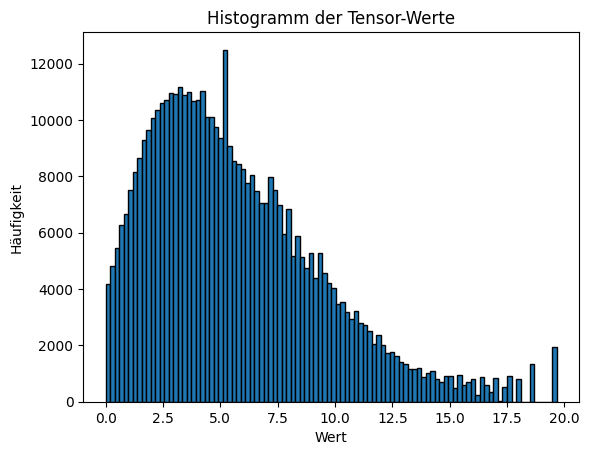

In [ ]:
plt.hist(data[edge_type].edge_attr.numpy(), bins=100, edgecolor='black')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Tensor-Werte')
plt.show()

In [ ]:
data.edge_attrs

<bound method BaseData.edge_attrs of HeteroData(
  paper={
    num_nodes=10000,
    license=[10000],
    doi=[10000],
    title=[10000],
    pages=[10000],
    journal=[10000],
    date=[10000],
    id=[10000],
  },
  author={
    num_nodes=25295,
    name={'Müller B.', 'Hazemann Jean-Louis', 'Yafaev D.', 'Garay Mauricio D.', 'Shen Junhao', 'Khaidukov Yu. N.', 'Sakon I.', 'Gambardella P.', 'Roeder Kathryn', 'Conradi Simone', 'Petra S. J. H.', 'Spiller Jonathan M.', 'Lunin Oleg', 'Negueruela Ignacio  Universidad de Alicante', 'Kouno Hiroaki  Saga Univ.', 'Blasi Pasquale', 'Zumbrun Kevin', 'Sanchez-Conde Miguel A.', 'Mcadrecki Andrzej', 'Guirado J. C.', 'Sénéchal David', 'Cherrington J. Wade', 'Hogerheijde M. R.', 'Nzeutchap Janvier', 'Anderson B. P.', 'Patwardhan Ajay', 'Silveira D. M.', 'Korkusinski M.', 'Kochanek C. S.', 'Ricci Riccardo', 'Kraft M.', 'Mocko M.', 'Strieder F.', 'Nowak Edmund R', 'Kamenik Jernej', 'Cordier B.', 'Saturnino Daniela', 'Runkel Ingo', 'Los J. H.', 'Nassimi A

In [ ]:
print(data.node_types)
print(data.edge_types)

['paper', 'author', 'category', 'journal', 'word']
[('paper', 'written_by', 'author'), ('paper', 'has_category', 'category'), ('paper', 'has_word', 'word'), ('paper', 'has_titleword', 'word'), ('paper', 'in_journal', 'journal-ref'), ('word', 'co_occurs_with', 'word')]


## Scale weights for training??

# Export

In [ ]:
import pickle

# Serialize and save the hetero-object
with open('hetero_graph.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Load the hetero-object
with open('hetero_graph.pkl', 'rb') as f:
    loaded_hetero_graph = pickle.load(f)
loaded_hetero_graph["author"]

{'num_nodes': 25295, 'name': {'Müller B.', 'Hazemann Jean-Louis', 'Yafaev D.', 'Garay Mauricio D.', 'Shen Junhao', 'Khaidukov Yu. N.', 'Sakon I.', 'Gambardella P.', 'Roeder Kathryn', 'Conradi Simone', 'Petra S. J. H.', 'Spiller Jonathan M.', 'Lunin Oleg', 'Negueruela Ignacio  Universidad de Alicante', 'Kouno Hiroaki  Saga Univ.', 'Blasi Pasquale', 'Zumbrun Kevin', 'Sanchez-Conde Miguel A.', 'Mcadrecki Andrzej', 'Guirado J. C.', 'Sénéchal David', 'Cherrington J. Wade', 'Hogerheijde M. R.', 'Nzeutchap Janvier', 'Anderson B. P.', 'Patwardhan Ajay', 'Silveira D. M.', 'Korkusinski M.', 'Kochanek C. S.', 'Ricci Riccardo', 'Kraft M.', 'Mocko M.', 'Strieder F.', 'Nowak Edmund R', 'Kamenik Jernej', 'Cordier B.', 'Saturnino Daniela', 'Runkel Ingo', 'Los J. H.', 'Nassimi Ali Mohammad', 'Lee Taeyoung', 'Lee Seung J.', 'Petry Walter', 'Lee Sung-Ik', 'Fan Yi-Zhong', 'Azzam Luay', 'Özyilmaz Barbaros', 'Campbell D. K.', 'Nishi Yoshifumi', 'Leroy Antoine  TIMC -\n  IMAG', 'Roche J.', 'Ullmo Denis', 'Am

# Visualization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import Counter
from math import log
import torch
import networkx as nx
import matplotlib.pyplot as plt

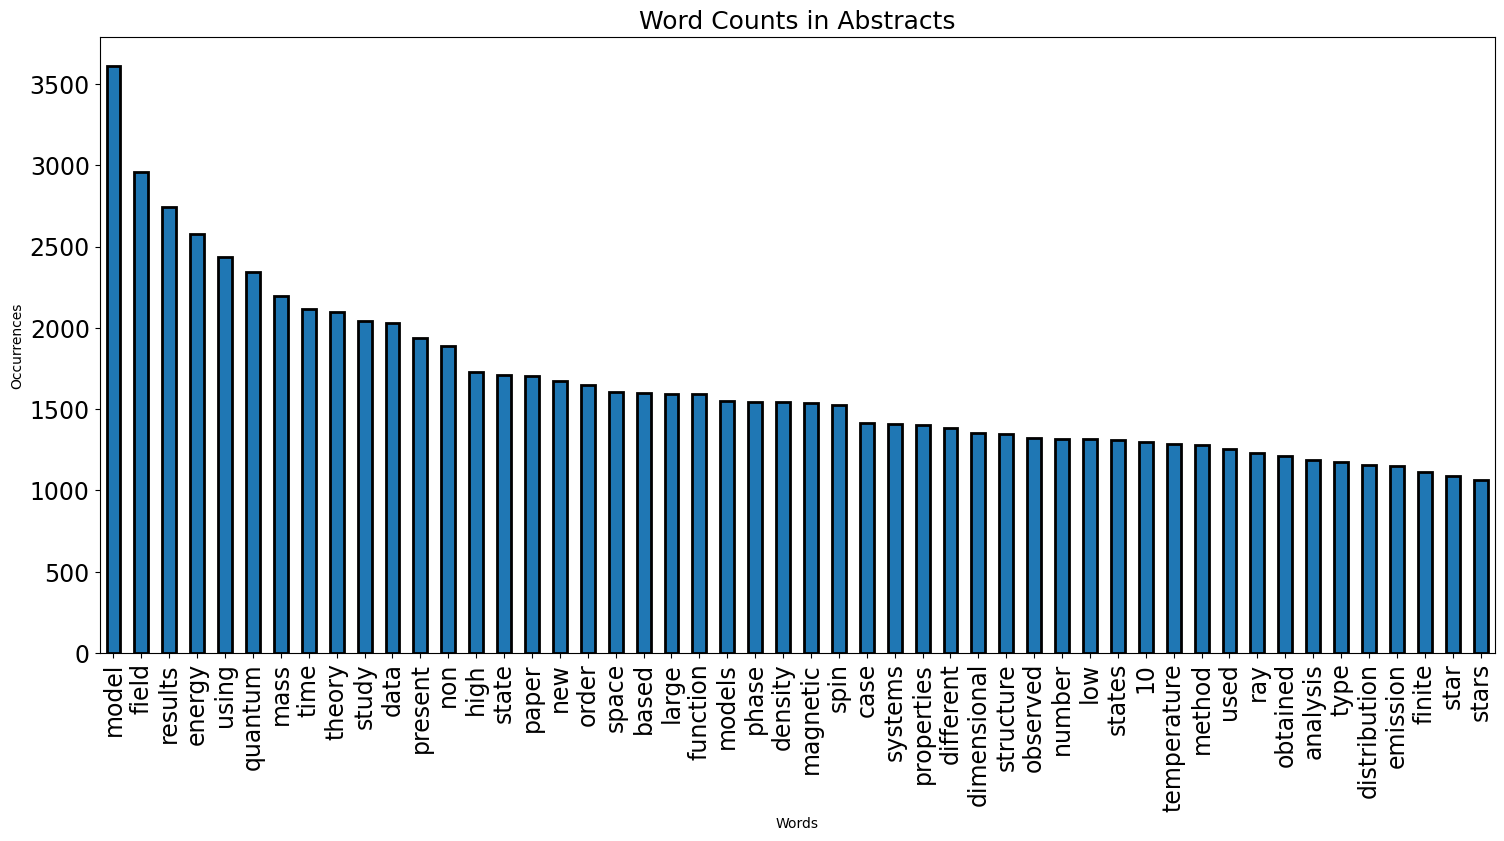

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ihr DataFrame und die Spalte 'abstract'
abstracts = df_short['abstract'].tolist()

counter = CountVectorizer(stop_words='english')
count_matrix = counter.fit_transform(abstracts)

# Verwenden Sie die entsprechende Methode je nach Ihrer scikit-learn Version
try:
    features = counter.get_feature_names_out()
except AttributeError:
    features = counter.get_feature_names()

abstracts_counter = pd.Series(count_matrix.toarray().sum(axis=0), 
                              index=features).sort_values(ascending=False)

bar_graph = abstracts_counter[:50].plot(kind='bar', figsize=(18,8), alpha=1, fontsize=17, rot=90, edgecolor='black', linewidth=2,
            title='Word Counts in Abstracts')
bar_graph.set_xlabel('Words')
bar_graph.set_ylabel('Occurrences')
bar_graph.title.set_size(18)
plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import networkx as nx
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from collections import Counter
# import math
# import itertools

# # Angenommen, df ist Ihr DataFrame mit einer Spalte 'document' für Dokumente
# documents = df['title'][:1].tolist()

# # Berechnung der TF-IDF-Werte
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Erstellung des Graphen
# G = nx.Graph()

# # Hinzufügen von Dokument- und Wortknoten
# for doc_id, doc in enumerate(documents):
#     G.add_node(f'doc_{doc_id}', type='document')

# for word in feature_names:
#     G.add_node(word, type='word')

# # Hinzufügen von Dokument-Wort-Kanten mit TF-IDF-Gewichtungen
# for doc_id in range(tfidf_matrix.shape[0]):
#     for word_id in tfidf_matrix[doc_id].nonzero()[1]:
#         tfidf_weight = tfidf_matrix[doc_id, word_id]
#         G.add_edge(f'doc_{doc_id}', feature_names[word_id], weight=tfidf_weight)
#         print(f"doc_id: {doc_id}, word_id: {feature_names[word_id]}, weight: {tfidf_weight}")
        
# # Berechnung der PMI-Werte für Wort-Wort-Kanten
# word_counts = Counter(np.array(tfidf_matrix.sum(axis=0)).flatten())
# total_count = sum(word_counts.values())
# word_pairs = itertools.combinations(feature_names, 2)

# for word1, word2 in word_pairs:
#     count_word1 = word_counts[word1]
#     count_word2 = word_counts[word2]
#     count_word1_word2 = (tfidf_matrix[:, feature_names.tolist().index(word1)] 
#                          + tfidf_matrix[:, feature_names.tolist().index(word2)]).sum()
#     pmi = math.log((count_word1_word2 * total_count) / (count_word1 * count_word2), 2)
#     if pmi > 0:
#         G.add_edge(word1, word2, weight=pmi)

# # Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
# plt.rcParams['text.usetex'] = False

# # circular_layout sonst Zahl zu groß für Visualisierung von pmi, davor spring genommen
# pos = nx.circular_layout(G)  # Layout des Graphen
# nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')

# # # Gewichte der Kanten holen
# # edge_weights = nx.get_edge_attributes(G, 'weight')
# # # Kanten-Labels zeichnen
# # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=5)

# plt.title("Graph Representation of the ArXiv Dataset")
# plt.show()